In [1]:
# Cell 1 (fixed): parse name -> cdna, ref_parsed, alt_parsed, protein_change
import pandas as pd, re, os

proc_dir = r"/mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed"
in_path = os.path.join(proc_dir, "clinvar_stage3_with_af.csv")
out_path = os.path.join(proc_dir, "clinvar_subset_parsed_real.csv")

df = pd.read_csv(in_path, low_memory=False)
print("Loaded rows:", len(df))
print("Columns:", df.columns.tolist()[:30])

# safer parse function returning a dict so we can build a dataframe
def parse_name_row(name):
    if pd.isna(name):
        return {"cdna": None, "ref_parsed": None, "alt_parsed": None, "protein_change": None}
    # try to find c. notation with single-letter ref>alt (e.g. c.1144C>T)
    cdna_m = re.search(r"c\.([0-9_+\-]+)?([ACGT])>([ACGT])", str(name))
    # sometimes del/ins: c.1234del, c.123_125del, c.123_124ins... we ignore those for ref/alt extraction
    prot_m = re.search(r"p\.([A-Za-z]{3})(\d+)([A-Za-z]{3}|\*)", str(name))
    cdna = cdna_m.group(0) if cdna_m else None
    refp = cdna_m.group(2) if cdna_m else None
    altp = cdna_m.group(3) if cdna_m else None
    prot = prot_m.group(0) if prot_m else None
    return {"cdna": cdna, "ref_parsed": refp, "alt_parsed": altp, "protein_change": prot}

# apply parsing to all rows (fast-ish)
parsed_df = df["name"].apply(parse_name_row).apply(pd.Series)

# attach parsed columns to original df (do not use join to avoid column-name collision)
for c in parsed_df.columns:
    df[c] = parsed_df[c]

# quick diagnostics
print("\nParsed columns added. Sample counts (non-null):")
print(df[["cdna","ref_parsed","alt_parsed","protein_change"]].notnull().sum())

print("\nFirst 10 rows (name, cdna, ref_parsed, alt_parsed, protein_change, label):")
print(df[["name","cdna","ref_parsed","alt_parsed","protein_change","label"]].head(10).to_string(index=False))

# save parsed file
df.to_csv(out_path, index=False)
print("\nSaved parsed dataset to:", out_path)

Loaded rows: 809642
Columns: ['variationid', 'gene', 'chr', 'pos', 'ref', 'alt', 'name', 'clinicalsignificance', 'rsid', 'label', 'cdna', 'protein_change', 'ref_aa', 'pos_aa', 'alt_aa', 'blosum62_raw', 'hydropathy_diff', 'is_stop', 'allele_freq']

Parsed columns added. Sample counts (non-null):
cdna              490411
ref_parsed        490411
alt_parsed        490411
protein_change    206927
dtype: int64

First 10 rows (name, cdna, ref_parsed, alt_parsed, protein_change, label):
                                          name        cdna ref_parsed alt_parsed protein_change  label
NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs)        None       None       None           None      1
NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs)        None       None       None           None      1
   NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter)    c.694C>T          C          T    p.Gln232Ter      1
   NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter)    c.694C>T          C          T    p.Gln232Ter      1


In [2]:
# Cell 2: extract ref_aa, pos_aa, alt_aa from protein_change
three_to_one = {
    'Ala':'A','Arg':'R','Asn':'N','Asp':'D','Cys':'C',
    'Gln':'Q','Glu':'E','Gly':'G','His':'H','Ile':'I',
    'Leu':'L','Lys':'K','Met':'M','Phe':'F','Pro':'P',
    'Ser':'S','Thr':'T','Trp':'W','Tyr':'Y','Val':'V',
    'Ter':'*'
}
import re
def parse_protein_token(p):
    if pd.isna(p):
        return pd.Series({"ref_aa": None, "pos_aa": None, "alt_aa": None})
    s = str(p).strip()
    # 3-letter to 1-letter pattern: p.Gln382Ter or p.Gln382Arg
    m = re.match(r"p\.([A-Za-z]{3})(\d+)([A-Za-z]{3}|\*)", s)
    if m:
        ref3, pos, alt3 = m.groups()
        ref1 = three_to_one.get(ref3.capitalize(), None)
        alt1 = three_to_one.get(alt3.capitalize(), None) if alt3 != "*" else "*"
        return pd.Series({"ref_aa": ref1, "pos_aa": int(pos), "alt_aa": alt1})
    # fallback: 1-letter pattern like p.R72H
    m2 = re.match(r"p\.([A-Za-z])(\d+)([A-Za-z]|\*)", s)
    if m2:
        ref1, pos, alt1 = m2.groups()
        return pd.Series({"ref_aa": ref1.upper(), "pos_aa": int(pos), "alt_aa": alt1.upper()})
    return pd.Series({"ref_aa": None, "pos_aa": None, "alt_aa": None})

# apply to the parsed file (reload if needed)
parsed_path = out_path  # from previous cell
dfp = pd.read_csv(parsed_path, low_memory=False)
df_parsed_prot = dfp["protein_change"].apply(parse_protein_token)
dfp["ref_aa"] = df_parsed_prot["ref_aa"]
dfp["pos_aa"] = df_parsed_prot["pos_aa"]
dfp["alt_aa"] = df_parsed_prot["alt_aa"]

print("AA parse counts (non-null):", dfp[["ref_aa","alt_aa"]].notnull().sum().to_dict())
display(dfp[["name","protein_change","ref_aa","pos_aa","alt_aa","label"]].head(10))

# save
out2 = os.path.join(proc_dir, "clinvar_subset_parsed_realaa.csv")
dfp.to_csv(out2, index=False)
print("Saved with AA columns to:", out2)

AA parse counts (non-null): {'ref_aa': 206927, 'alt_aa': 203371}


,name,protein_change,ref_aa,pos_aa,alt_aa,label
0,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),NaN,None,NaN,None,1
1,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),NaN,None,NaN,None,1
2,NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter),p.Gln232Ter,Q,232.0,*,1
3,NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter),p.Gln232Ter,Q,232.0,*,1
4,NM_000410.4(HFE):c.892+48G>A,NaN,None,NaN,None,0
5,NM_000410.4(HFE):c.892+48G>A,NaN,None,NaN,None,0
6,NM_000410.4(HFE):c.989G>T (p.Arg330Met),p.Arg330Met,R,330.0,M,1
7,NM_000410.4(HFE):c.989G>T (p.Arg330Met),p.Arg330Met,R,330.0,M,1
8,NM_020779.4(WDR35):c.25-2A>G,NaN,None,NaN,None,1
9,NM_020779.4(WDR35):c.25-2A>G,NaN,None,NaN,None,1


Saved with AA columns to: /mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_subset_parsed_realaa.csv


In [12]:
import pandas as pd
from Bio.Align import substitution_matrices
import os

# Correct path (NO double "processed")
CSV = "/mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_subset_parsed_realaa.csv"

# Check actual existence
print("Checking:", CSV)
print("Exists?", os.path.exists(CSV))

# Load your file
df = pd.read_csv(CSV)
print("Loaded:", CSV, "shape:", df.shape)

# Load BLOSUM62
blosum62 = substitution_matrices.load("BLOSUM62")
aa_list = blosum62.alphabet

def get_blosum62(ref_aa, alt_aa):
    if pd.isna(ref_aa) or pd.isna(alt_aa):
        return float("nan")

    ref_aa = str(ref_aa).upper()
    alt_aa = str(alt_aa).upper()

    if ref_aa == "*" or alt_aa == "*" or len(ref_aa) != 1 or len(alt_aa) != 1:
        return float("nan")

    if ref_aa not in aa_list or alt_aa not in aa_list:
        return float("nan")

    try:
        return blosum62[aa_list.index(ref_aa), aa_list.index(alt_aa)]
    except:
        return float("nan")

# Compute BLOSUM62
df["blosum62_raw"] = df.apply(
    lambda r: get_blosum62(r["ref_aa"], r["alt_aa"]),
    axis=1
)

OUT = "/mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_with_blosum62.csv"
df.to_csv(OUT, index=False)

print("✔ Saved with BLOSUM62:", OUT)
print(df["blosum62_raw"].describe())


Checking: /mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_subset_parsed_realaa.csv
Exists? True
Loaded: /mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_subset_parsed_realaa.csv shape: (809642, 21)
✔ Saved with BLOSUM62: /mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_with_blosum62.csv
count    109152.000000
mean         -0.546229
std           1.645171
min          -4.000000
25%          -2.000000
50%          -1.000000
75%           1.000000
max           3.000000
Name: blosum62_raw, dtype: float64


Loading CSV (this may take a few seconds)...
Loaded: /mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_with_blosum62.csv shape: (809642, 21)

Columns (first 40): ['variationid', 'gene', 'chr', 'pos', 'ref', 'alt', 'name', 'clinicalsignificance', 'rsid', 'label', 'cdna', 'protein_change', 'ref_aa', 'pos_aa', 'alt_aa', 'blosum62_raw', 'hydropathy_diff', 'is_stop', 'allele_freq', 'ref_parsed', 'alt_parsed']

Label counts (raw):
label
0    422583
1    387059
Name: count, dtype: int64
label_numeric counts:
 label_numeric
0    422583
1    387059
Name: count, dtype: Int64

Data summary (first 20 rows):


,dtype,non_null,missing_pct
variationid,int64,809642,0.000000
gene,object,809642,0.000000
chr,object,809642,0.000000
pos,int64,809642,0.000000
ref,object,809642,0.000000
alt,object,809642,0.000000
name,object,809642,0.000000
clinicalsignificance,object,809642,0.000000
rsid,int64,809642,0.000000
label,int64,809642,0.000000



=== CLASS BALANCE ===
label_numeric
0    422583
1    387059
Total labeled rows: 809642, Positive fraction (pathogenic=1): 0.478


/tmp/ipykernel_625/2174924558.py:143: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['benign (0)','pathogenic (1)'])


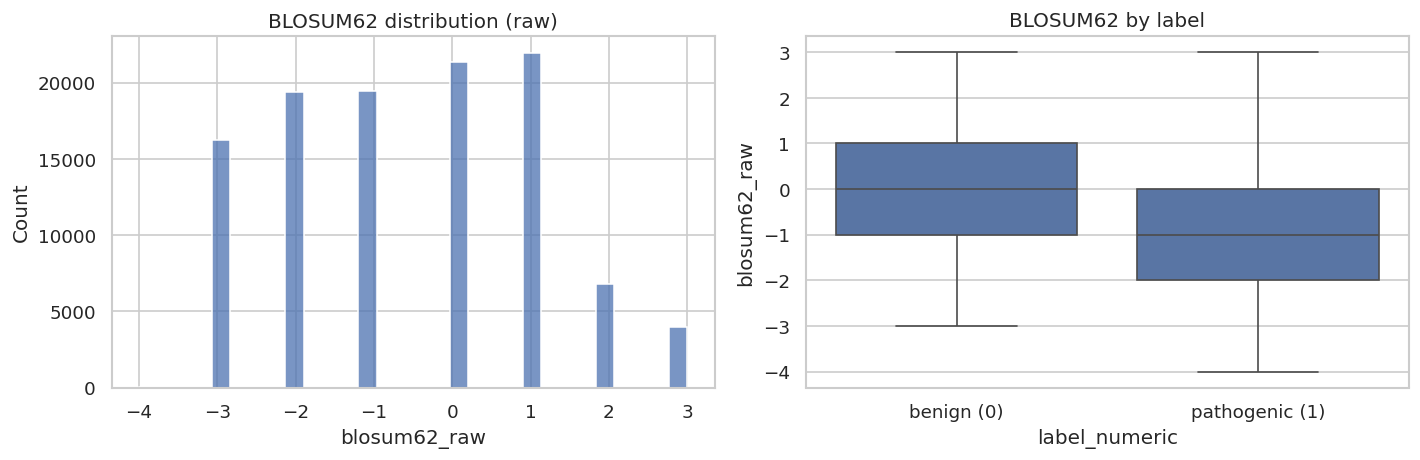

Saved: results/eda/blosum62_dist_and_box.png


/tmp/ipykernel_625/2174924558.py:159: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['benign (0)','pathogenic (1)'])


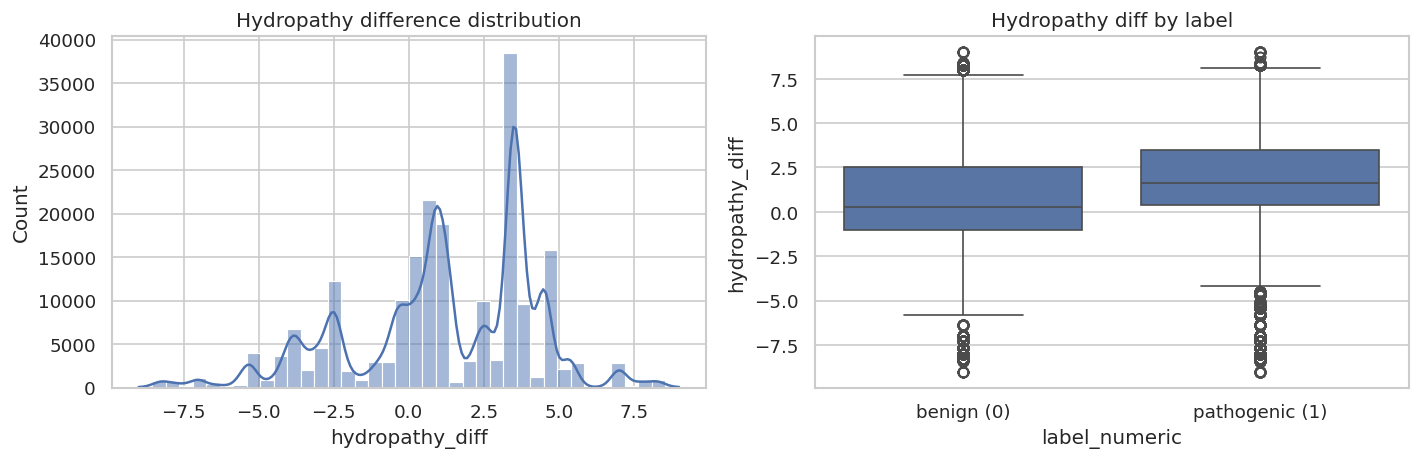

Saved: results/eda/hydropathy_dist_and_box.png


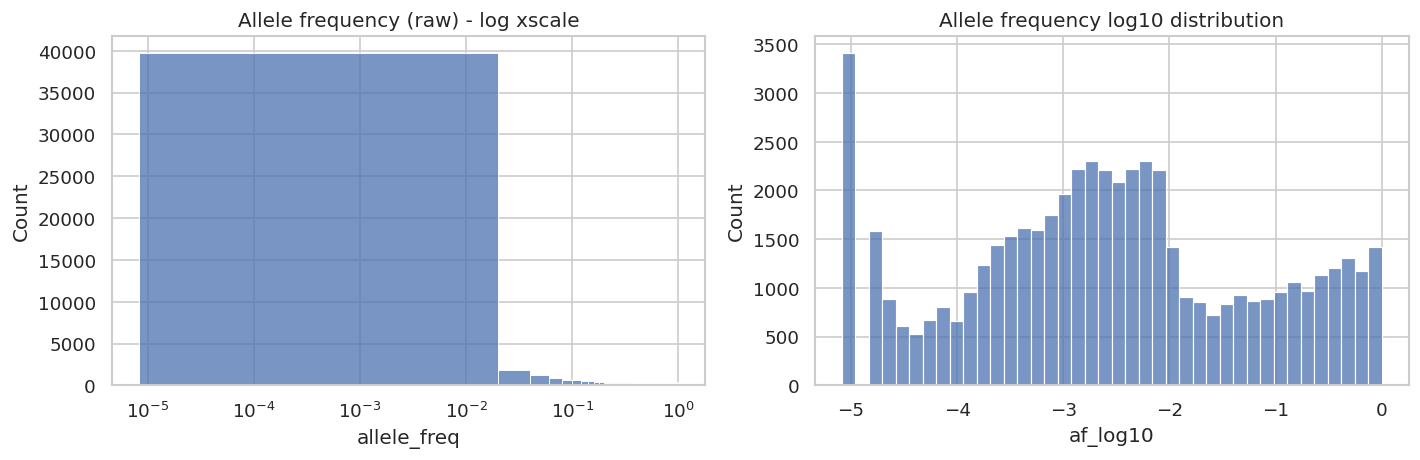

Saved: results/eda/allele_freq_dist.png


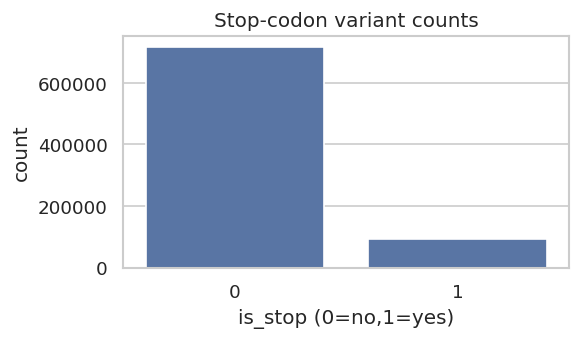

Saved: results/eda/is_stop_counts.png
is_stop counts:
 is_stop
0    715643
1     93999

Numeric columns considered for correlation: ['variationid', 'pos', 'rsid', 'label', 'pos_aa', 'blosum62_raw', 'hydropathy_diff', 'is_stop', 'allele_freq', 'label_numeric', 'af_log10']


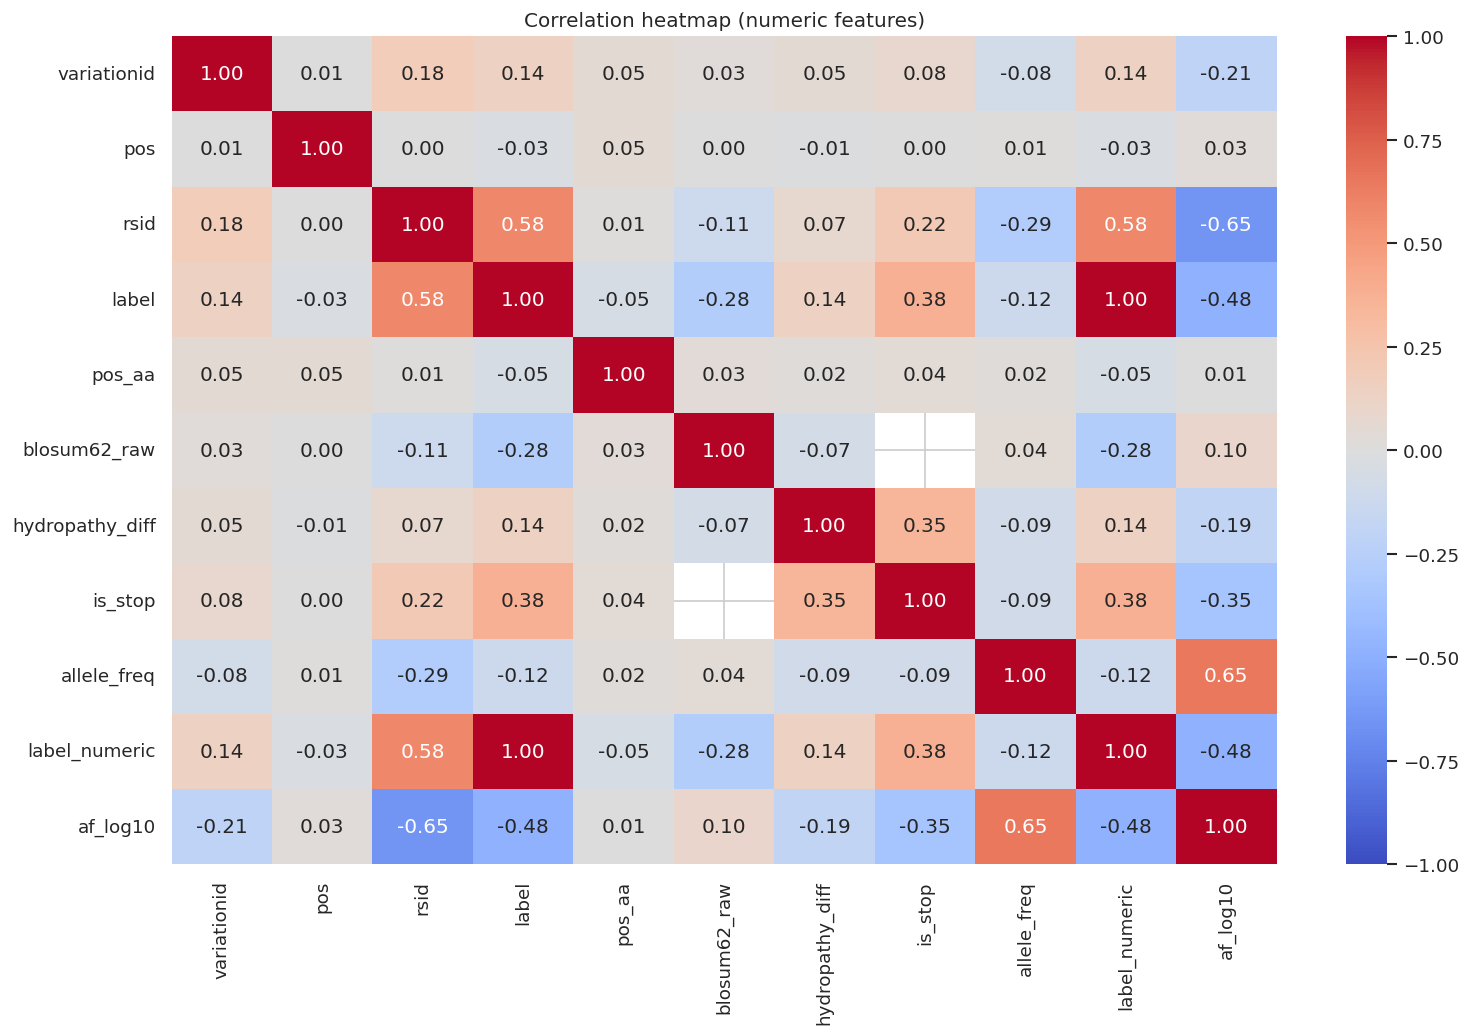

Saved: results/eda/correlation_heatmap.png


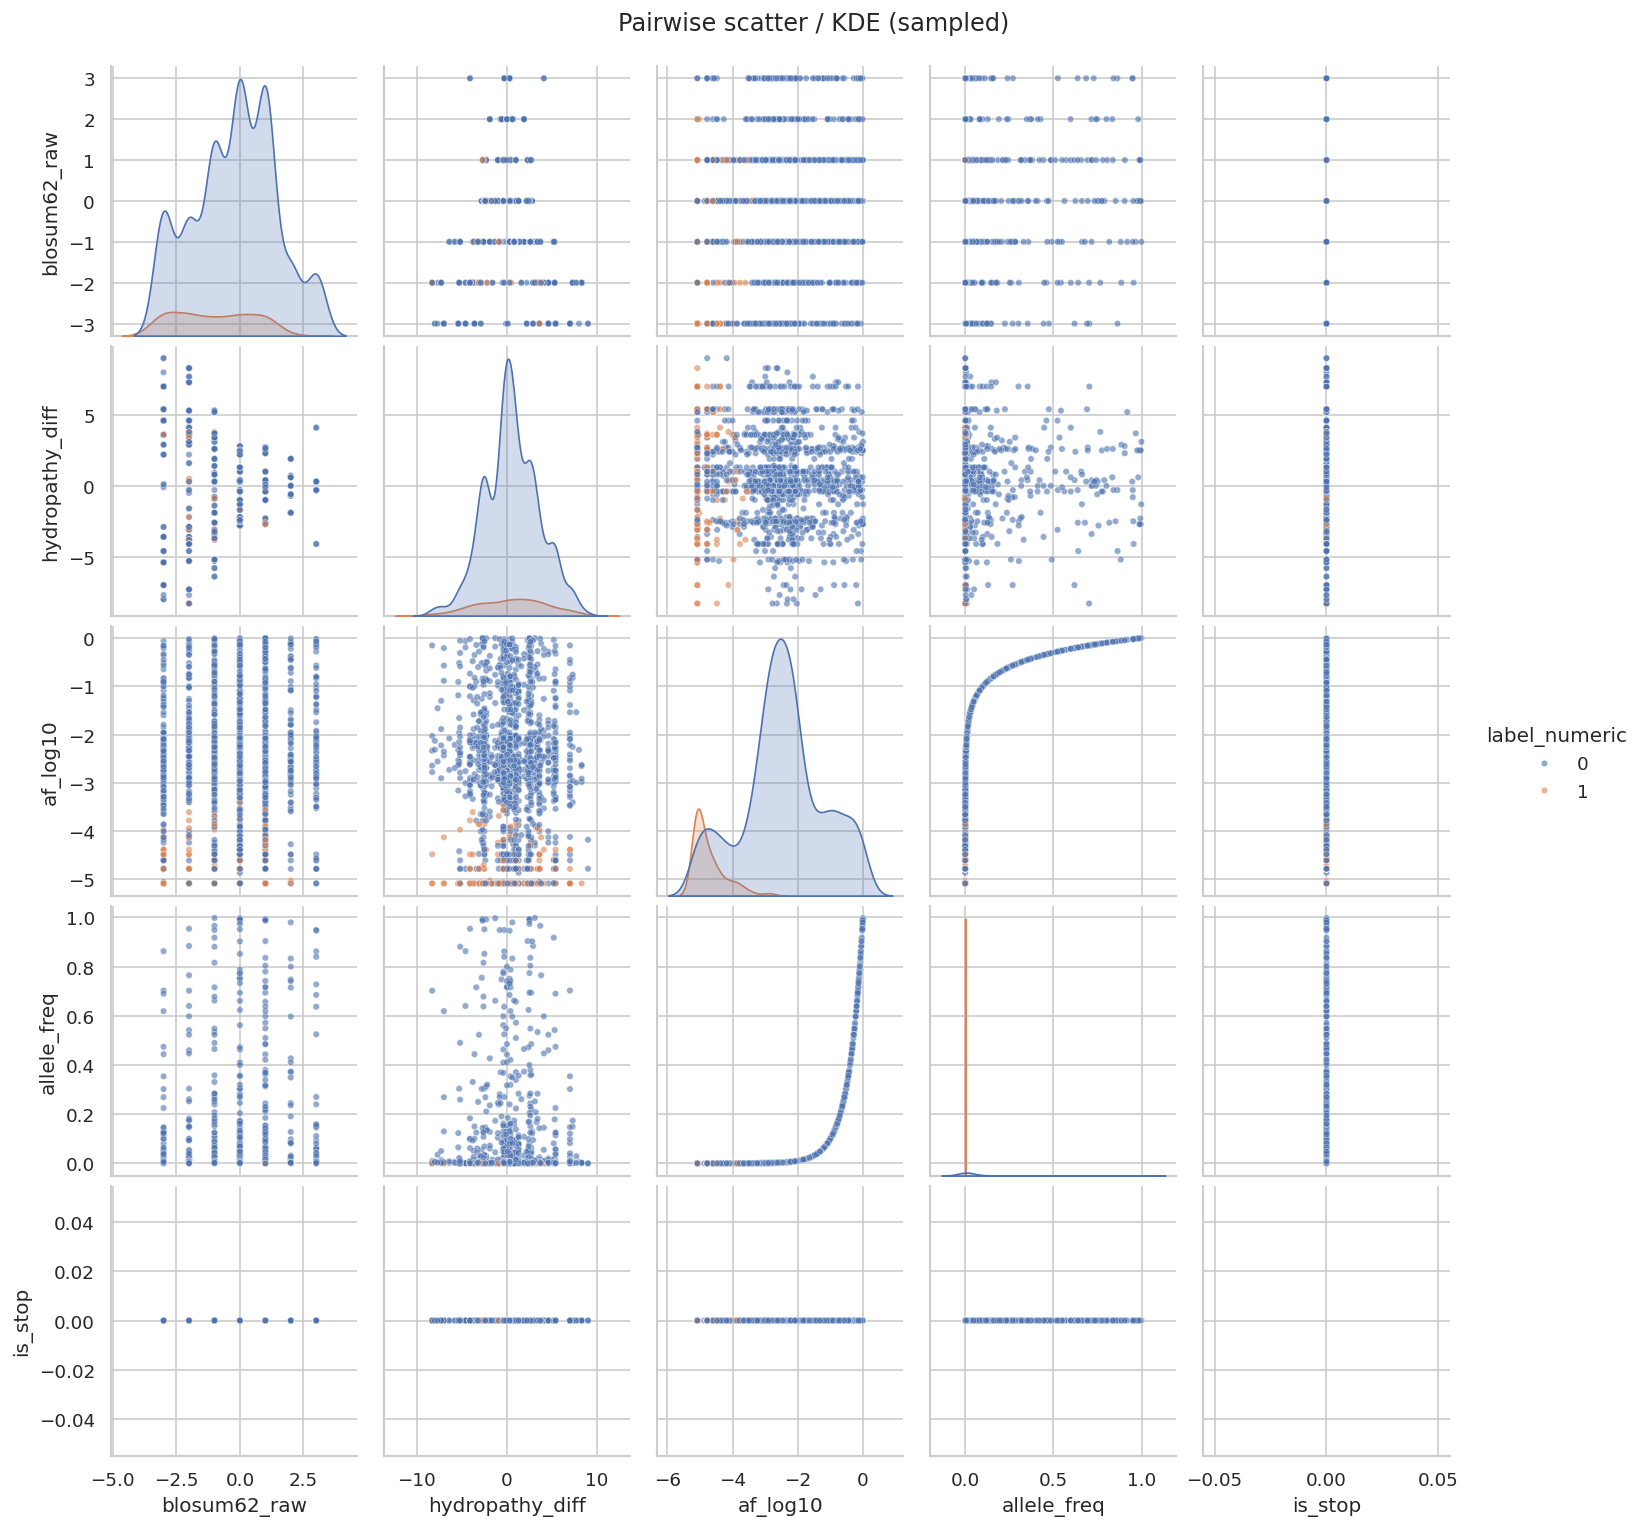

Saved: results/eda/pairplot_sample.png


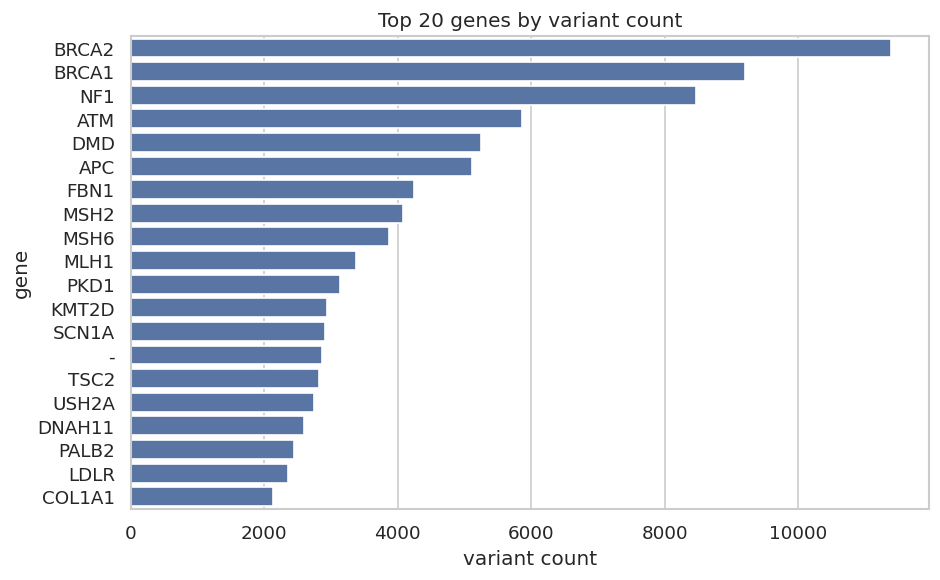

Saved: results/eda/top20_genes_counts.png

--- EDA complete ---
Results saved under: /home/mygenome/results/eda
If the script picked the wrong CSV file, set CSV_PATH variable at the top to the correct path and re-run.


In [13]:
# Robust EDA runner: finds ClinVar CSV automatically (or you can override)

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os, sys
from pathlib import Path
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

CSV_PATH = (r"/mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_with_blosum62.csv")
SEARCH_DIRS = [Path.cwd(), Path.cwd()/"data", Path.cwd()/"data"/"processed", Path("/mnt/c/Users")]

def find_candidates(search_dirs, names):
    found = []
    for d in search_dirs:
        d = Path(d)
        if not d.exists():
            continue
        # exact names
        for n in names:
            p = d / n
            if p.exists():
                found.append(p)
        # wildcard clinvar*.csv
        for p in d.glob("clinvar*.csv"):
            found.append(p)
    # dedupe preserving order
    seen = set()
    uniq = []
    for p in found:
        if str(p) not in seen:
            uniq.append(p)
            seen.add(str(p))
    return uniq

# If user set CSV_PATH manually above, use it; else search
if CSV_PATH is None:
    candidates = find_candidates(SEARCH_DIRS, candidate_names)
    if len(candidates) == 0:
        # fallback: list current dir and data subdirs
        print("No candidate clinvar CSV found in default search directories.")
        print("Files in current directory:")
        for p in Path.cwd().iterdir():
            print(" ", p.name)
        print("\nTry setting CSV_PATH manually to the correct file path, e.g.\nCSV_PATH = Path('data/processed/clinvar_fixed_labels.csv')\n")
        raise FileNotFoundError("No clinvar CSV found. See printed file list above.")
    else:
        print("Found these candidate CSV files (first will be used):")
        for i,p in enumerate(candidates):
            print(f" {i+1}. {p}  (size: {p.stat().st_size/1024/1024:.2f} MB)")
        CSV_PATH = candidates[0]
        print("\nUsing:", CSV_PATH)
else:
    CSV_PATH = Path(CSV_PATH)
    if not CSV_PATH.exists():
        raise FileNotFoundError(f"CSV_PATH set but file not found: {CSV_PATH}")

# ---------- Now load CSV (with memory-safe options) ----------
print("Loading CSV (this may take a few seconds)...")
# try pandas with low_memory
df = pd.read_csv(CSV_PATH, low_memory=False)
print("Loaded:", CSV_PATH, "shape:", df.shape)

# ---------- EDA (robust to missing columns) ----------
OUT = Path("results/eda")
OUT.mkdir(parents=True, exist_ok=True)

# Standardize column names for checks
cols = [c.strip() for c in df.columns]
print("\nColumns (first 40):", cols[:40])

# Ensure numeric columns
for c in ["blosum62_raw","hydropathy_diff","is_stop","allele_freq","pos_aa","pos"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# label numeric mapping (robust)
if "label" in df.columns:
    df["label_str"] = df["label"].astype(str)
    mapping = {'pathogenic':1, 'benign':0, 'likely_pathogenic':1, 'likely_benign':0}
    df["label_numeric"] = df["label_str"].str.lower().map(mapping)
    if df["label_numeric"].isna().all():
        # try numeric conversion
        try:
            df["label_numeric"] = pd.to_numeric(df["label"], errors="coerce").astype("Int64")
        except:
            pass
else:
    df["label_numeric"] = pd.NA

print("\nLabel counts (raw):")
if "label" in df.columns:
    print(df["label"].value_counts(dropna=False).head(10))
print("label_numeric counts:\n", df["label_numeric"].value_counts(dropna=False))

# quick summary table
info_df = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "missing_pct": 100*(1 - df.notna().mean())
})
print("\nData summary (first 20 rows):")
display(info_df.head(20))

# CLASS BALANCE
print("\n=== CLASS BALANCE ===")
if df["label_numeric"].notna().sum() == 0:
    print("No numeric label found (label_numeric empty). If labels are strings like 'Pathogenic', map them or provide label_numeric column.")
else:
    counts = df["label_numeric"].value_counts(dropna=False)
    total = counts.sum()
    print(counts.to_string())
    print(f"Total labeled rows: {total}, Positive fraction (pathogenic=1): {counts.get(1,0)/total:.3f}")

# Helper to save figures
def save_fig(fig, name):
    path = OUT / f"{name}.png"
    fig.savefig(path, bbox_inches="tight", dpi=150)
    print("Saved:", path)

# BLOSUM distribution & boxplot
if "blosum62_raw" in df.columns:
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(df["blosum62_raw"].dropna(), bins=30, kde=False, ax=axes[0])
    axes[0].set_title("BLOSUM62 distribution (raw)")
    if df["label_numeric"].notna().sum() > 0:
        sns.boxplot(data=df.dropna(subset=["label_numeric","blosum62_raw"]), x="label_numeric", y="blosum62_raw", ax=axes[1])
        axes[1].set_xticklabels(['benign (0)','pathogenic (1)'])
    else:
        axes[1].text(0.5,0.5,"No numeric label to split by", ha="center")
    axes[1].set_title("BLOSUM62 by label")
    plt.tight_layout(); plt.show()
    save_fig(fig, "blosum62_dist_and_box")
else:
    print("No blosum62_raw column found.")

# Hydropathy distribution & boxplot
if "hydropathy_diff" in df.columns:
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(df["hydropathy_diff"].dropna(), bins=40, kde=True, ax=axes[0])
    axes[0].set_title("Hydropathy difference distribution")
    if df["label_numeric"].notna().sum() > 0:
        sns.boxplot(data=df.dropna(subset=["label_numeric","hydropathy_diff"]), x="label_numeric", y="hydropathy_diff", ax=axes[1])
        axes[1].set_xticklabels(['benign (0)','pathogenic (1)'])
    else:
        axes[1].text(0.5,0.5,"No numeric label to split by", ha="center")
    axes[1].set_title("Hydropathy diff by label")
    plt.tight_layout(); plt.show()
    save_fig(fig, "hydropathy_dist_and_box")
else:
    print("No hydropathy_diff column found.")

# Allele freq distributions
if "allele_freq" in df.columns:
    df["af_log10"] = np.log10(df["allele_freq"].replace(0, np.nan)).replace(-np.inf, np.nan)
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(df["allele_freq"].dropna(), bins=50, ax=axes[0])
    axes[0].set_xscale('log')
    axes[0].set_title("Allele frequency (raw) - log xscale")
    sns.histplot(df["af_log10"].dropna(), bins=40, ax=axes[1])
    axes[1].set_title("Allele frequency log10 distribution")
    plt.tight_layout(); plt.show()
    save_fig(fig, "allele_freq_dist")
else:
    print("No allele_freq column found.")

# is_stop counts
if "is_stop" in df.columns:
    stop_counts = df["is_stop"].fillna(0).astype(int).value_counts()
    fig, ax = plt.subplots(figsize=(5,3))
    sns.barplot(x=stop_counts.index.astype(str), y=stop_counts.values, ax=ax)
    ax.set_xlabel("is_stop (0=no,1=yes)")
    ax.set_ylabel("count")
    ax.set_title("Stop-codon variant counts")
    plt.tight_layout(); plt.show()
    save_fig(fig, "is_stop_counts")
    print("is_stop counts:\n", stop_counts.to_string())
else:
    print("No is_stop column found.")

# Correlation heatmap (numeric columns only)
numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
if "label_numeric" in df.columns and "label_numeric" not in numeric_cols:
    numeric_cols.append("label_numeric")
numeric_cols = list(dict.fromkeys(numeric_cols))  # dedupe
print("\nNumeric columns considered for correlation:", numeric_cols)
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr()
    fig, ax = plt.subplots(figsize=(max(6,1.2*len(numeric_cols)), max(4,0.8*len(numeric_cols))))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
    ax.set_title("Correlation heatmap (numeric features)")
    plt.tight_layout(); plt.show()
    save_fig(fig, "correlation_heatmap")
else:
    print("Not enough numeric columns for correlation heatmap.")

# Pairplot for a small subset (sampled)
candidates = [c for c in ["blosum62_raw","hydropathy_diff","af_log10","allele_freq","is_stop","pos_aa"] if c in df.columns]
pair_vars = candidates[:5]
if len(pair_vars) >= 2:
    sample = df.dropna(subset=pair_vars + (["label_numeric"] if "label_numeric" in df.columns else []))
    sample = sample.sample(n=min(1500, len(sample)), random_state=0)
    g = sns.pairplot(sample[pair_vars + (["label_numeric"] if "label_numeric" in sample.columns else [])], hue="label_numeric" if "label_numeric" in sample.columns else None, diag_kind="kde",
                     plot_kws={"alpha":0.6, "s":15})
    plt.suptitle("Pairwise scatter / KDE (sampled)", y=1.02)
    plt.show()
    g.savefig(OUT / "pairplot_sample.png")
    print("Saved:", OUT / "pairplot_sample.png")
else:
    print("Not enough features for pairplot. Candidates:", candidates)

# Top genes by variant count
if "gene" in df.columns:
    top_genes = df["gene"].value_counts().head(20)
    fig, ax = plt.subplots(figsize=(8,5))
    sns.barplot(y=top_genes.index, x=top_genes.values, ax=ax)
    ax.set_title("Top 20 genes by variant count")
    ax.set_xlabel("variant count")
    plt.tight_layout(); plt.show()
    save_fig(fig, "top20_genes_counts")
else:
    print("No gene column present.")

# Final summary
print("\n--- EDA complete ---")
print("Results saved under:", OUT.resolve())
print("If the script picked the wrong CSV file, set CSV_PATH variable at the top to the correct path and re-run.")
